In [15]:
import medmnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers, models
import torch
from torchvision import transforms
from torchvision.models import resnet18, densenet121, vgg16, ResNet18_Weights, DenseNet121_Weights, VGG16_Weights


In [16]:
dataVal = medmnist.BreastMNIST(split="val", download=True, size=64)
x_val = np.array([i[0] for i in dataVal])
y_val = np.array([i[1][0] for i in dataVal])

dataTest = medmnist.BreastMNIST(split="test", download=True, size=64)
x_test = np.array([i[0] for i in dataTest])
y_test = np.array([i[1][0] for i in dataTest])

In [17]:
# Para Keras
x_val_keras = x_val / 255.0
x_val_keras = np.expand_dims(x_val_keras, axis=-1)
x_test_keras = x_test / 255.0
x_test_keras = np.expand_dims(x_test_keras, axis=-1)

# Para PyTorch
transform_torch = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])
x_val_torch = torch.stack([transform_torch(img.astype(np.uint8)) for img in x_val])
x_test_torch = torch.stack([transform_torch(img.astype(np.uint8)) for img in x_test])

In [25]:
from tensorflow.keras.models import load_model

mejor_modelo_base = load_model('mejor_modelo_base.keras')

In [26]:

# Función para cargar modelos con la cabeza modificada
def load_tl_model(name, path):
    if name == 'resnet':
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
        in_features = model.fc.in_features
        model.fc = torch.nn.Sequential(torch.nn.Linear(in_features, 1), torch.nn.Sigmoid())
    elif name == 'densenet':
        model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        in_features = model.classifier.in_features
        model.classifier = torch.nn.Sequential(torch.nn.Linear(in_features, 1), torch.nn.Sigmoid())
    elif name == 'vgg':
        model = vgg16(weights=VGG16_Weights.DEFAULT)
        in_features = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Sequential(torch.nn.Linear(in_features, 1), torch.nn.Sigmoid())
    model.load_state_dict(torch.load(path, map_location='cpu'))
    model.eval()
    return model

resnet_model = load_tl_model('resnet', 'resnet_model.pth')
densenet_model = load_tl_model('densenet', 'densenet_model.pth')
vgg_model = load_tl_model('vgg', 'vgg_model.pth')

In [27]:
# Cargar datos de validación y test
dataVal = medmnist.BreastMNIST(split="val", download=True, size=64)
x_val = np.array([i[0] for i in dataVal])
y_val = np.array([i[1][0] for i in dataVal])

dataTest = medmnist.BreastMNIST(split="test", download=True, size=64)
x_test = np.array([i[0] for i in dataTest])
y_test = np.array([i[1][0] for i in dataTest])

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score

# Función para imprimir métricas
def print_metrics(y_true, y_pred, y_prob, model_name):
    print(f"Métricas para {model_name}:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print("PR AUC:", average_precision_score(y_true, y_prob))
    print("-" * 40)

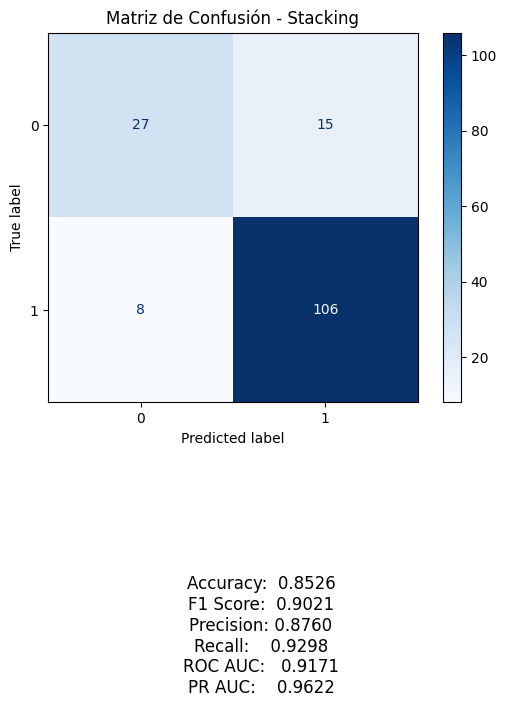

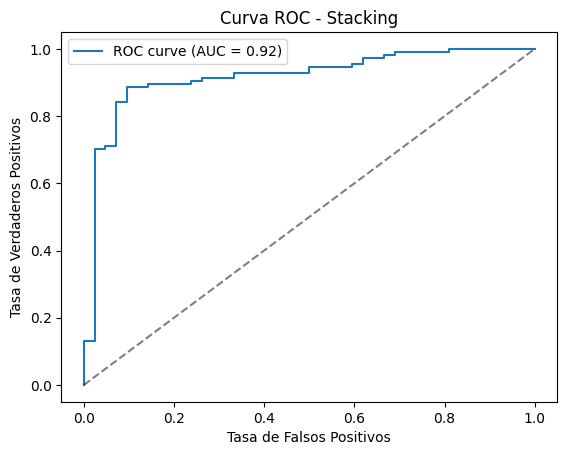

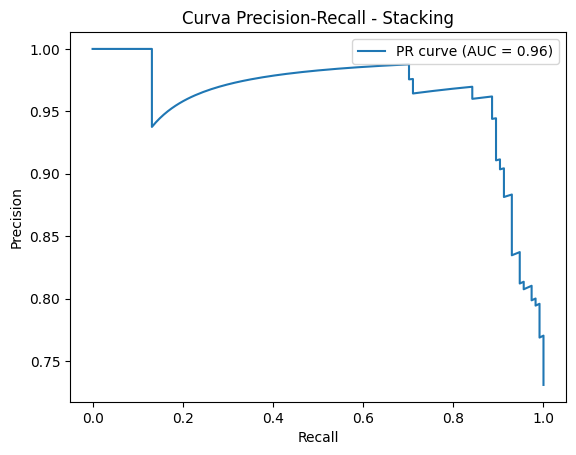

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

# 1. Predicciones de modelos base sobre val y test
def get_preds_keras(model, x):
    return model.predict(x, verbose=0).ravel()

def get_preds_torch(model, x):
    with torch.no_grad():
        outputs = model(x).cpu().numpy().ravel()
    return outputs

# Predicciones en val
preds_val_keras = get_preds_keras(mejor_modelo_base, x_val_keras)
preds_val_resnet = get_preds_torch(resnet_model, x_val_torch)
preds_val_densenet = get_preds_torch(densenet_model, x_val_torch)
preds_val_vgg = get_preds_torch(vgg_model, x_val_torch)

# Predicciones en test
preds_test_keras = get_preds_keras(mejor_modelo_base, x_test_keras)
preds_test_resnet = get_preds_torch(resnet_model, x_test_torch)
preds_test_densenet = get_preds_torch(densenet_model, x_test_torch)
preds_test_vgg = get_preds_torch(vgg_model, x_test_torch)

# 2. Stack de features para meta-modelo
X_val_stack = np.stack([preds_val_keras, preds_val_resnet, preds_val_densenet, preds_val_vgg], axis=1)
X_test_stack = np.stack([preds_test_keras, preds_test_resnet, preds_test_densenet, preds_test_vgg], axis=1)

# 3. Entrenar meta-modelo (solo con val)
meta_model = LogisticRegression()
meta_model.fit(X_val_stack, y_val)

# 4. Evaluar en test
y_pred_test = meta_model.predict(X_test_stack)
y_pred_test_prob = meta_model.predict_proba(X_test_stack)[:,1]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de Confusión - Stacking")

# Métricas principales bajo la matriz
acc = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_test_prob)
pr_auc = average_precision_score(y_test, y_pred_test_prob)

# Mostrar métricas como texto bajo la matriz
metrics_text = (
    f"Accuracy:  {acc:.4f}\n"
    f"F1 Score:  {f1:.4f}\n"
    f"Precision: {prec:.4f}\n"
    f"Recall:    {rec:.4f}\n"
    f"ROC AUC:   {roc_auc:.4f}\n"
    f"PR AUC:    {pr_auc:.4f}"
)
plt.gcf().text(0.5, -0.25, metrics_text, fontsize=12, ha='center', va='top')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Stacking')
plt.legend()
plt.show()

# Curva Precision-Recall
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_test_prob)
plt.figure()
plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Stacking')
plt.legend()
plt.show()